In [1]:
import numpy as np
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from spine_detector.utils import load_mri_research
import matplotlib.pyplot as plt

In [2]:
first_patient_path = '../test-data/0001'
T1_research = f'{first_patient_path}/T1_TSE_SAG_320_0003'

pixel_arrays, raw_dicoms = load_mri_research(T1_research)

Пробуем через дисперсию  
Будем проходить матрицей (3, 3, 3) по всему объекту и записывать значение дисперсии
в центральную ячейку
Затем строим гистограмму значений дисперсии по всему объекту


In [3]:
original_data = np.zeros((15,320, 320))

for i,array in enumerate(pixel_arrays):
    original_data[i] = array

In [4]:
dispersion_matrix = np.zeros_like(original_data)
for x in range(1, original_data.shape[0] - 1):
    for y in range(1, original_data.shape[1] - 1):
        for z in range(1, original_data.shape[2]- 1):
            dispersion_matrix[x][y][z] = np.var(original_data[x-1:x+1,y-1:y+1, z-1:z+1])

max 201871.75


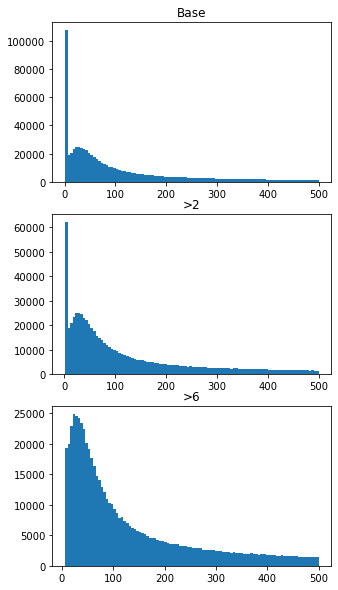

In [5]:
print(f'max {dispersion_matrix.max()}')
fig, ax = plt.subplots(3, figsize=(5, 10))

ax[0].set_title('Base')
ax[0].hist(dispersion_matrix[1:13].flat, bins=100, range=(1,500))

ax[1].set_title('>2')
ax[1].hist(dispersion_matrix[1:13].flat, bins=100, range=(2,500))

ax[2].set_title('>6')
ax[2].hist(dispersion_matrix[1:13].flat, bins=100, range=(6,500))

plt.show()

Поробуем отобразить 6 слой 

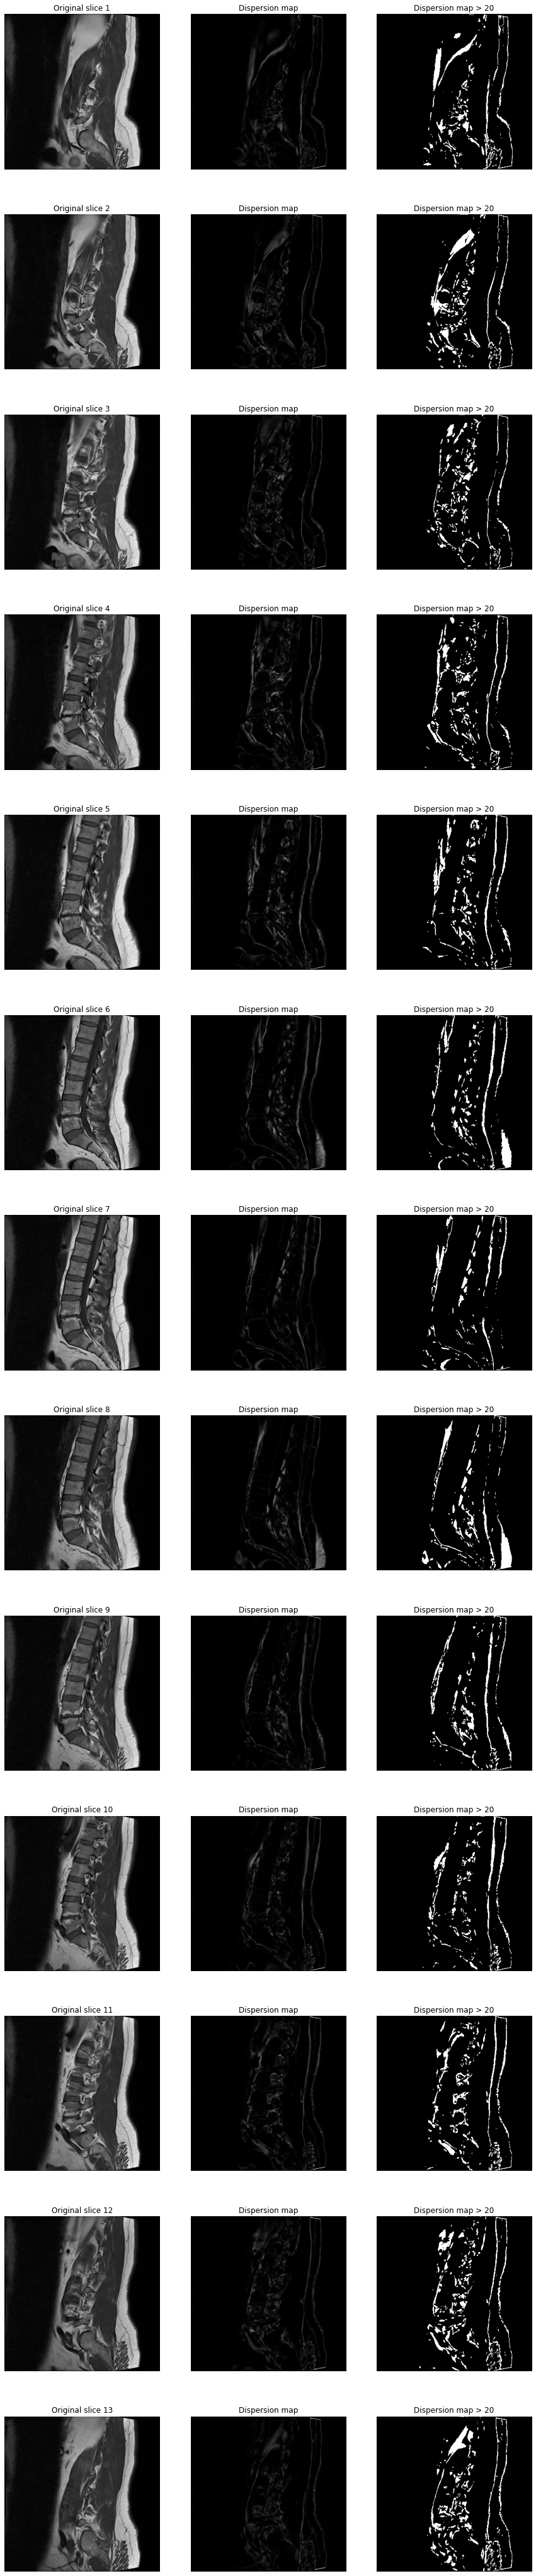

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=13, figsize=(15, 75))
coef = 20
max_dispersion = dispersion_matrix.max()
for i in range(1, 14):
    tst_disp = dispersion_matrix[i]
    tst_disp = 255 * tst_disp / max_dispersion
    
    ax[i-1][0].set_title(f'Original slice {i}')
    ax[i-1][0].imshow(pixel_arrays[i], cmap='gray')
    ax[i-1][0].axis('off')
    
    ax[i-1][1].set_title('Dispersion map')
    ax[i-1][1].imshow(tst_disp, cmap='gray')
    ax[i-1][1].axis('off')
    
    tst_disp_2 = tst_disp > coef
    
    ax[i-1][2].set_title(f'Dispersion map > {coef}')
    ax[i-1][2].imshow(tst_disp_2, cmap='gray')
    ax[i-1][2].axis('off')

plt.show()

Получается убрать мессиво при помощи дисперсии  
По сути мы можем сделать доп маску для, что вычищать всякий шлак с слоев  
```
    tst_disp = 255 * tst_disp / tst_disp.max()
    ...
    tst_disp_2 = tst_disp > 20
```
Значение дисперсии получается
15 * dispersion_matrix.max() / 255
Как будто 15 - оптимально

In [13]:
from skimage.filters import threshold_otsu

def otsu_filtering(original_pixel_array):
    """
    Данный делает следующее:
        * высчитывает трешхолд по отцу
        * накладывает маску
        * возращает pixel_array отрабатанный по маске
    :param original_pixel_array:
    :return:
    """
    thresh = threshold_otsu(original_pixel_array)
    bw = closing(original_pixel_array > thresh, square(1))

    # set borders with 5
    bw[:, 5] = True
    bw[:, 315] = True
    bw[5, :] = True
    bw[315, :] = True

    cleared = clear_border(bw)

    cleared_pixel_array = original_pixel_array * cleared

    return cleared_pixel_array

In [12]:
tst_disp = np.invert(dispersion_matrix[6] > 15)
tst_image = pixel_arrays[6]

In [ ]:
after_otsu = otsu_filtering(tst_image)

fig, ax = plt.subplots(ncols=3, figuresize=(15,5))

ax[0].set_title('Origina image')
ax[0].imshow(tst_image, cmap='gray')
ax[0].axis('off')

ax[1].set_title('After otsu')
ax[1].imshow(after_otsu, cmap='gray')
ax[1].axis('off')

after_dispersion = tst_image * tst_disp

ax[2].set_title('After otsu and dispersion')
ax[2].imshow(after_dispersion, cmap='gray')
ax[2].axis('off')

plt.show()